In [1]:
from matplotlib import pyplot as plt
import polars as pl
import polars_h3 as plh3

from copy import deepcopy

from tqdm import tqdm

In [2]:
traffic = pl.read_parquet('../for_participants/data_parquet/traffic_train.parquet')

signals = pl.read_parquet('../for_participants/data_parquet/signals.parquet')
roads = pl.read_parquet('../for_participants/data_parquet/roads.parquet')
pois = pl.read_parquet('../for_participants/data_parquet/pois.parquet')
buildings = pl.read_parquet('../for_participants/data_parquet/buildings.parquet')
demography = pl.read_parquet('../for_participants/data_parquet/demography.parquet')

signals = signals.with_columns([
    plh3.cell_to_latlng("h3res13").list.to_struct(fields=["lat", "lon"]).alias("latlng")
]).unnest("latlng")

roads = roads.with_columns([
    plh3.cell_to_latlng("h3res13").list.to_struct(fields=["lat", "lon"]).alias("latlng")
]).unnest("latlng")

pois = pois.with_columns([
    plh3.cell_to_latlng("h3res13").list.to_struct(fields=["lat", "lon"]).alias("latlng")
]).unnest("latlng")

buildings = buildings.with_columns([
    plh3.cell_to_latlng("h3res13").list.to_struct(fields=["lat", "lon"]).alias("latlng")
]).unnest("latlng")

demography = demography.with_columns([
    plh3.cell_to_latlng("h3res13").list.to_struct(fields=["lat", "lon"]).alias("latlng")
]).unnest("latlng")

In [3]:
def get_relevant_things(data_df, window_size=0.02):
    data_filtered = data_df.filter(
        (pl.col("lat") >= lat - window_size) & (pl.col("lat") <= lat + window_size) &
        (pl.col("lon") >= lon - window_size) & (pl.col("lon") <= lon + window_size)
    ).with_columns(
        [
            pl.lit(lat).alias("station_lat"),
            pl.lit(lon).alias("station_lon")
        ]
    ).with_columns(
        [
            plh3.great_circle_distance(
                "lat", "lon", "station_lat", "station_lon", unit="km"
            ).alias('distance_from_station_km')
        ]
    ).filter(
        pl.col('distance_from_station_km') <= 1
    )
    return data_filtered

In [4]:

all_relevant_roads = []
all_relevant_pois = []
all_relevant_buildings = []
all_relevant_demography = []
all_relevant_signals = []

for station_id in tqdm(list(traffic['station_id'].unique())):
    lat = traffic.filter(pl.col('station_id') == station_id)['lat'][0]
    lon = traffic.filter(pl.col('station_id') == station_id)['lon'][0]

    all_relevant_roads.append(get_relevant_things(roads).with_columns(pl.lit(station_id).alias('station_id')))
    all_relevant_pois.append(get_relevant_things(pois).with_columns(pl.lit(station_id).alias('station_id')))
    all_relevant_buildings.append(get_relevant_things(buildings).with_columns(pl.lit(station_id).alias('station_id')))
    all_relevant_demography.append(get_relevant_things(demography).with_columns(pl.lit(station_id).alias('station_id')))
    all_relevant_signals.append(get_relevant_things(signals).with_columns(pl.lit(station_id).alias('station_id')))

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


In [5]:
df_relevant_roads = pl.concat(all_relevant_roads, how='vertical')
df_relevant_pois = pl.concat(all_relevant_pois, how='vertical')
df_relevant_buildings = pl.concat(all_relevant_buildings, how='vertical')
df_relevant_demography = pl.concat(all_relevant_demography, how='vertical')
df_relevant_signals = pl.concat(all_relevant_signals, how='vertical')

In [6]:
def filter_df(
    data_df,
    station_id,
    radius,
    filter_date=None,
    prefix=''
):

    cols_to_remove = ['h3res13', 'lat', 'lon', 'station_id', 'building_id', 'building_function', 'station_lat', 'station_lon', 'distance_from_station_km', 'signal_date']
    
    cols_to_remove_table = [x for x in cols_to_remove if x in data_df.columns]

    if not filter_date:
        filtered_data = data_df.filter(
            pl.col('station_id') == station_id,
            pl.col('distance_from_station_km') < radius
        ).drop(
            cols_to_remove_table
        )
    else:
        filtered_data = data_df.filter(
            pl.col('station_id') == station_id,
            pl.col('distance_from_station_km') < radius,
            pl.col('signal_date') == traffic_date
        ).drop(
            cols_to_remove_table
        )
        
    return {
        f"{prefix}{col}_mean_radius_{radius}": row[col]
        for row in filtered_data.mean().iter_rows(named=True)
        for col in filtered_data.columns
        if col in row
    } | {
        f"{prefix}{col}_max_radius_{radius}": row[col]
        for row in filtered_data.max().iter_rows(named=True)
        for col in filtered_data.columns
        if col in row and col != 'weekday'
    }

In [7]:
roads_radius = 0.2
pois_radius = 0.5
buildings_radius = 0.5
demography_radius = 0.5
signals_radius = 0.25

final_station_ids = []
final_dates = []
final_X = []
final_y = []


for station_id in tqdm(list(traffic['station_id'].unique())):
    if station_id in ['3310' '3379' '5342' '5368']:
        continue
    lat = traffic.filter(pl.col('station_id') == station_id)['lat'][0]
    lon = traffic.filter(pl.col('station_id') == station_id)['lon'][0]

    common_data = {}

    common_data = common_data | filter_df(df_relevant_roads, station_id, roads_radius, prefix='roads_')
    common_data = common_data | filter_df(df_relevant_pois, station_id, pois_radius, prefix='pois_')
    common_data = common_data | filter_df(df_relevant_buildings, station_id, buildings_radius, prefix='buildings_')
    common_data = common_data | filter_df(df_relevant_demography, station_id, demography_radius, prefix='demography_')

    for traffic_date in traffic.filter(pl.col('station_id') == station_id)['date'].unique():
        observation_data = deepcopy(common_data)
        observation_data = observation_data | filter_df(
            df_relevant_signals,
            station_id,
            signals_radius,
            filter_date=traffic_date,
            prefix='signals_'
        )

        target = traffic.filter(
            pl.col('station_id') == station_id,
            pl.col('date') == traffic_date
        )['traffic'].quantile(0.95)

        final_station_ids.append(station_id)
        final_dates.append(traffic_date)
        final_X.append(observation_data)
        final_y.append(target)

final_station_ids = pl.Series(final_station_ids) 
final_dates = pl.Series(final_dates) 
final_X = pl.DataFrame(final_X) 
final_y = pl.Series(final_y) 

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [03:38<00:00,  3.12s/it]


In [8]:
final_X = final_X.fill_nan(0)
final_X = final_X.fill_null(0)

In [26]:
# X = final_X[[x for x in final_X.columns if x.split('_')[0] in ['signals', 'pois']]]
X = final_X[[x for x in final_X.columns ]]

final_cols = ['signals_weekday_mean_radius_0.25', 'signals_ctd_per_day_mean_radius_0.25', 'signals_ctn_per_day_mean_radius_0.25', 'signals_ctd_6_mean_radius_0.25', 'signals_ctd_5_mean_radius_0.25', 'signals_ctd_8_mean_radius_0.25', 'signals_ctd_7_mean_radius_0.25', 'signals_ctn_12_max_radius_0.25', 'signals_ctd_15_mean_radius_0.25', 'signals_ctn_7_mean_radius_0.25', 'signals_ctd_14_mean_radius_0.25', 'signals_ctn_6_mean_radius_0.25', 'signals_ctn_5_mean_radius_0.25', 'signals_ctd_10_mean_radius_0.25', 'signals_ctn_14_mean_radius_0.25', 'signals_ctd_13_mean_radius_0.25', 'signals_ctd_21_mean_radius_0.25', 'signals_ctn_8_max_radius_0.25', 'signals_ctd_3_max_radius_0.25', 'signals_ctn_10_mean_radius_0.25', 'roads_primary_mean_radius_0.2', 'roads_secondary_mean_radius_0.2', 'pois_public_service_and_government_mean_radius_0.5', 'pois_education_mean_radius_0.5', 'buildings_building_area_max_radius_0.5', 'buildings_building_flats_mean_radius_0.5', 'demography_male0018_mean_radius_0.5', 'demography_female6599_max_radius_0.5']

X = final_X[final_cols]

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import polars as pl
import joblib

# Ensure results folder exists
os.makedirs("results", exist_ok=True)

X_np = X.to_numpy()
y_np = final_y.to_numpy().ravel()
station_ids_np = final_station_ids.to_numpy()

unique_stations = final_station_ids.unique().to_numpy()
np.random.seed(42)
np.random.shuffle(unique_stations)
folds = np.array_split(unique_stations, 5)

for max_depth in range(2, 12):
    all_val_preds = []
    all_val_true = []
    all_folds = []
    results = []

    for fold_idx, val_stations in enumerate(folds, start=1):
        val_mask = np.isin(station_ids_np, val_stations)
        train_mask = ~val_mask

        X_train, y_train = X_np[train_mask], y_np[train_mask]
        X_val, y_val = X_np[val_mask], y_np[val_mask]

        model = RandomForestRegressor(n_estimators=200, max_depth=max_depth)
        model.fit(X_train, y_train)

        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)

        all_val_preds.append(val_preds)
        all_val_true.append(y_val)
        all_folds.extend([fold_idx] * len(y_val))

        rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
        rmse_val = np.sqrt(mean_squared_error(y_val, val_preds))
        r2_train = r2_score(y_train, train_preds)
        r2_val = r2_score(y_val, val_preds)

        results.append({
            "fold": fold_idx,
            "rmse_train": rmse_train,
            "rmse_val": rmse_val,
            "r2_train": r2_train,
            "r2_val": r2_val
        })

        print(f"[max_depth={max_depth}] Fold {fold_idx}: RMSE_val={rmse_val:.3f}, R2_val={r2_val:.3f}")

    # Save report
    report_path = f"results/report_max_depth_{max_depth}.md"
    with open(report_path, "w") as f:
        f.write(f"# Report for max_depth={max_depth}\n\n")
        df = pl.DataFrame(results)
        f.write("## Fold Metrics\n")
        f.write(df.write_csv(separator="|"))
        f.write("\n\n## Averages\n")
        avg = df.select([
            pl.col("rmse_train").mean().alias("avg_rmse_train"),
            pl.col("rmse_val").mean().alias("avg_rmse_val"),
            pl.col("r2_train").mean().alias("avg_r2_train"),
            pl.col("r2_val").mean().alias("avg_r2_val")
        ])
        f.write(avg.write_csv(separator="|"))

    # Train on full data
    full_model = RandomForestRegressor(n_estimators=200, max_depth=max_depth)
    full_model.fit(X_np, y_np)
    joblib.dump(full_model, f"results/model_max_depth_{max_depth}.pkl")

    # Plot predictions
    all_val_preds = np.concatenate(all_val_preds)
    all_val_true = np.concatenate(all_val_true)
    all_folds_arr = np.array(all_folds)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(all_val_true, all_val_preds, c=all_folds_arr, cmap='tab10', alpha=0.7)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Validation Predictions vs. True (max_depth={max_depth})")
    plt.plot([all_val_true.min(), all_val_true.max()],
             [all_val_true.min(), all_val_true.max()], color='black', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"results/val_preds_vs_true_max_depth_{max_depth}.png")
    plt.close()

[max_depth=2] Fold 1: RMSE_val=1586.878, R2_val=0.368
[max_depth=2] Fold 2: RMSE_val=1578.807, R2_val=0.297
[max_depth=2] Fold 3: RMSE_val=1180.170, R2_val=0.489
[max_depth=2] Fold 4: RMSE_val=1312.242, R2_val=0.358
[max_depth=2] Fold 5: RMSE_val=1590.240, R2_val=0.188
[max_depth=3] Fold 1: RMSE_val=1707.889, R2_val=0.268
[max_depth=3] Fold 2: RMSE_val=1368.316, R2_val=0.472
[max_depth=3] Fold 3: RMSE_val=1083.722, R2_val=0.569
[max_depth=3] Fold 4: RMSE_val=1256.035, R2_val=0.412
[max_depth=3] Fold 5: RMSE_val=1556.177, R2_val=0.222
[max_depth=4] Fold 1: RMSE_val=1731.297, R2_val=0.248
[max_depth=4] Fold 2: RMSE_val=1402.686, R2_val=0.445
[max_depth=4] Fold 3: RMSE_val=940.690, R2_val=0.675
[max_depth=4] Fold 4: RMSE_val=1289.490, R2_val=0.380
[max_depth=4] Fold 5: RMSE_val=1464.568, R2_val=0.311
[max_depth=5] Fold 1: RMSE_val=1669.904, R2_val=0.300
[max_depth=5] Fold 2: RMSE_val=1463.021, R2_val=0.396
[max_depth=5] Fold 3: RMSE_val=996.732, R2_val=0.635
[max_depth=5] Fold 4: RMSE_val

In [42]:
os.makedirs("results/transfer", exist_ok=True)

# Get top 20% northern stations
unique_stations = traffic.select(["station_id", "lat", "lon"]).unique()
top_20_percent = unique_stations.sort("lat", descending=True).head(int(0.2 * unique_stations.height))
val_station_ids = set(top_20_percent["station_id"].to_numpy())

X_np = X.to_numpy()
y_np = final_y.to_numpy().ravel()
station_ids_np = final_station_ids.to_numpy()

val_mask = np.isin(station_ids_np, list(val_station_ids))
train_mask = ~val_mask

X_train, y_train = X_np[train_mask], y_np[train_mask]
X_val, y_val = X_np[val_mask], y_np[val_mask]

# Train model
model = RandomForestRegressor(n_estimators=200, max_depth=9)
model.fit(X_train, y_train)

train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
rmse_val = np.sqrt(mean_squared_error(y_val, val_preds))
r2_train = r2_score(y_train, train_preds)
r2_val = r2_score(y_val, val_preds)

# Print summary
print(f"[Transfer] RMSE_val={rmse_val:.3f}, R2_val={r2_val:.3f}")

# Save report
report_path = "results/transfer/report_transfer.md"
with open(report_path, "w") as f:
    f.write("# Transfer Learning Report (north-most validation)\n\n")
    f.write("## Metrics\n")
    f.write(f"- RMSE (Train): {rmse_train:.3f}\n")
    f.write(f"- RMSE (Val): {rmse_val:.3f}\n")
    f.write(f"- R2 (Train): {r2_train:.3f}\n")
    f.write(f"- R2 (Val): {r2_val:.3f}\n")

# Save model
joblib.dump(model, "results/transfer/model_transfer_max_depth_9.pkl")

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_val, val_preds, c='red', alpha=0.7, label='Validation (north-most)')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Transfer: Validation Predictions vs. True Values (north-most stations)")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig("results/transfer/val_preds_vs_true_transfer.png")
plt.close()

[Transfer] RMSE_val=1266.356, R2_val=0.425


shape: (5, 5)
┌──────┬────────────┬─────────────┬──────────┬───────────┐
│ fold ┆ rmse_train ┆ rmse_val    ┆ r2_train ┆ r2_val    │
│ ---  ┆ ---        ┆ ---         ┆ ---      ┆ ---       │
│ i64  ┆ f64        ┆ f64         ┆ f64      ┆ f64       │
╞══════╪════════════╪═════════════╪══════════╪═══════════╡
│ 1    ┆ 451.932357 ┆ 1475.1562   ┆ 0.92466  ┆ 0.609651  │
│ 2    ┆ 490.376535 ┆ 1495.912639 ┆ 0.937038 ┆ -0.870102 │
│ 3    ┆ 473.589801 ┆ 1474.759106 ┆ 0.926742 ┆ 0.463755  │
│ 4    ┆ 439.061729 ┆ 1602.566697 ┆ 0.943333 ┆ 0.068157  │
│ 5    ┆ 419.277208 ┆ 1104.632968 ┆ 0.949165 ┆ 0.513644  │
└──────┴────────────┴─────────────┴──────────┴───────────┘

Averages:
shape: (1, 4)
┌────────────────┬──────────────┬──────────────┬────────────┐
│ avg_rmse_train ┆ avg_rmse_val ┆ avg_r2_train ┆ avg_r2_val │
│ ---            ┆ ---          ┆ ---          ┆ ---        │
│ f64            ┆ f64          ┆ f64          ┆ f64        │
╞════════════════╪══════════════╪══════════════╪════════════╡
│ 

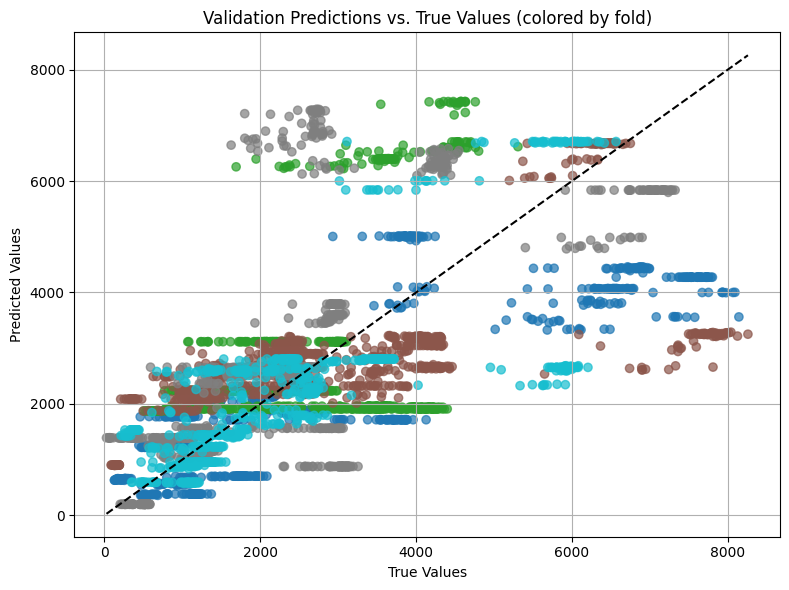

In [29]:
import matplotlib.pyplot as plt

# Store predictions for plotting
all_val_preds = []
all_val_true = []
all_folds = []

# Get unique station IDs and shuffle
unique_stations = final_station_ids.unique().to_numpy()
np.random.seed(42)
np.random.shuffle(unique_stations)

# Split into 5 folds
folds = np.array_split(unique_stations, 5)

results = []

X_np = X.to_numpy()
y_np = final_y.to_numpy().ravel()
station_ids_np = final_station_ids.to_numpy()

for fold_idx, val_stations in enumerate(folds, start=1):
    val_mask = np.isin(station_ids_np, val_stations)
    train_mask = ~val_mask

    X_train, y_train = X_np[train_mask], y_np[train_mask]
    X_val, y_val = X_np[val_mask], y_np[val_mask]

    model = RandomForestRegressor(n_estimators=200, max_depth=5)
    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Collect for plotting
    all_val_preds.append(val_preds)
    all_val_true.append(y_val)
    all_folds.extend([fold_idx] * len(y_val))

    rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
    rmse_val = np.sqrt(mean_squared_error(y_val, val_preds))
    r2_train = r2_score(y_train, train_preds)
    r2_val = r2_score(y_val, val_preds)

    results.append({
        "fold": fold_idx,
        "rmse_train": rmse_train,
        "rmse_val": rmse_val,
        "r2_train": r2_train,
        "r2_val": r2_val
    })

# Summary table
summary_df = pl.DataFrame(results)
print(summary_df)

# Averages
print("\nAverages:")
print(summary_df.select([
    pl.col("rmse_train").mean().alias("avg_rmse_train"),
    pl.col("rmse_val").mean().alias("avg_rmse_val"),
    pl.col("r2_train").mean().alias("avg_r2_train"),
    pl.col("r2_val").mean().alias("avg_r2_val")
]))

# Plot predictions vs true values, colored by fold
all_val_preds = np.concatenate(all_val_preds)
all_val_true = np.concatenate(all_val_true)
all_folds = np.array(all_folds)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(all_val_true, all_val_preds, c=all_folds, cmap='tab10', alpha=0.7)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Validation Predictions vs. True Values (colored by fold)")
plt.plot([all_val_true.min(), all_val_true.max()],
         [all_val_true.min(), all_val_true.max()], color='black', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

val_idx = final_station_ids.is_in(final_station_ids.unique().shuffle()[:10])

X_train = X.filter(~val_idx)
y_train = final_y.filter(~val_idx)

X_val = X.filter(val_idx)
y_val = final_y.filter(val_idx)

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10
)
model.fit(X_train, y_train)

# Predictions
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
rmse_val = np.sqrt(mean_squared_error(y_val, val_preds))

print(f"Train RMSE: {rmse_train:.4f}")
print(f"Validation RMSE: {rmse_val:.4f}")

from sklearn.metrics import r2_score


print(f"Train R2: {r2_score(y_train, train_preds):.4f}")
print(f"Validation R2: {r2_score(y_val, val_preds):.4f}")


Train RMSE: 194.3433
Validation RMSE: 848.9864
Train R2: 0.9894
Validation R2: 0.4750


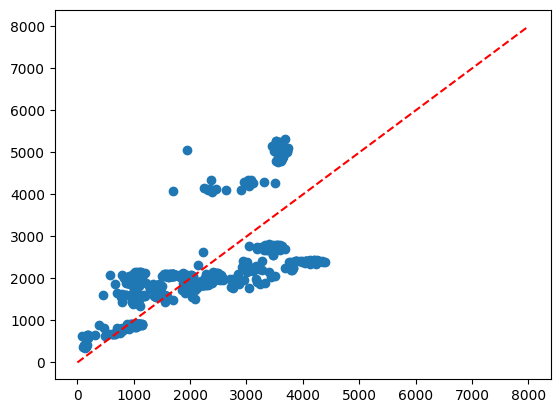

In [17]:
plt.scatter(y_val, val_preds)
plt.plot([0, 8000], [0, 8000], 'r--')

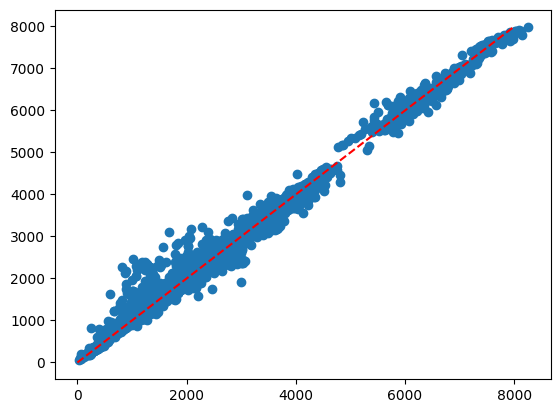

In [18]:
plt.scatter(y_train, train_preds)
plt.plot([0, 8000], [0, 8000], 'r--')

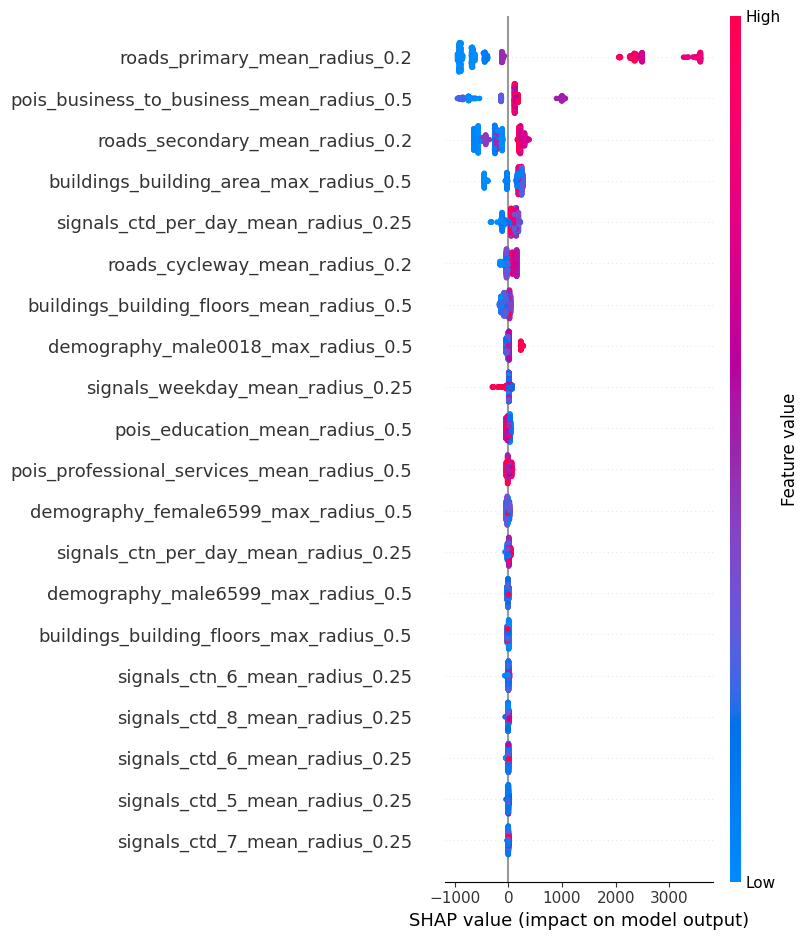

In [259]:
import shap

# Explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_val.to_numpy())

# Summary plot (for top features)
shap.summary_plot(shap_values, features=X_val.to_pandas(), feature_names=X_val.columns)

In [19]:
importances = model.feature_importances_
feature_names = X_train.columns
top_idx = np.argsort(importances)[::-1]
top_features = [feature_names[i] for i in top_idx]

import polars as pl
import numpy as np

# Parameters
k = 2

# Create DataFrame
df = pl.DataFrame({
    "feature": feature_names,
    "importance": importances
})

# Top 50 features
df_top = df.sort("importance", descending=True)

# Add group prefix
df_top = df_top.with_columns(
    pl.col("feature").str.split("_").list.get(0).alias("group")
)

# Separate signals group
signals_df = df_top.filter(
    pl.col("group") == "signals"
).sort(
    'importance', descending=True
)[:20]

# Other groups: keep top-k per group
other_df = (
    df_top.filter(pl.col("group") != "signals")
    .group_by("group", maintain_order=True)
    .agg([
        pl.col("feature").sort_by("importance", descending=True).head(k).alias("feature"),
        pl.col("importance").sort_by("importance", descending=True).head(k).alias("importance")
    ])
    .explode(["feature", "importance"])
).select(["feature", "importance"])

# Combine both
final_df = pl.concat([signals_df.select(["feature", "importance"]), other_df])
final_features = final_df["feature"].to_list()

print(final_features)

['signals_weekday_mean_radius_0.25', 'signals_ctd_per_day_mean_radius_0.25', 'signals_ctn_per_day_mean_radius_0.25', 'signals_ctd_6_mean_radius_0.25', 'signals_ctd_5_mean_radius_0.25', 'signals_ctd_8_mean_radius_0.25', 'signals_ctd_7_mean_radius_0.25', 'signals_ctn_12_max_radius_0.25', 'signals_ctd_15_mean_radius_0.25', 'signals_ctn_7_mean_radius_0.25', 'signals_ctd_14_mean_radius_0.25', 'signals_ctn_6_mean_radius_0.25', 'signals_ctn_5_mean_radius_0.25', 'signals_ctd_10_mean_radius_0.25', 'signals_ctn_14_mean_radius_0.25', 'signals_ctd_13_mean_radius_0.25', 'signals_ctd_21_mean_radius_0.25', 'signals_ctn_8_max_radius_0.25', 'signals_ctd_3_max_radius_0.25', 'signals_ctn_10_mean_radius_0.25', 'roads_primary_mean_radius_0.2', 'roads_secondary_mean_radius_0.2', 'pois_public_service_and_government_mean_radius_0.5', 'pois_education_mean_radius_0.5', 'buildings_building_area_max_radius_0.5', 'buildings_building_flats_mean_radius_0.5', 'demography_male0018_mean_radius_0.5', 'demography_female6

In [24]:
df_top.filter(
    pl.col("group") == "signals"
).sort(
    'importance', descending=True
)[:15]

feature,importance,group
str,f64,str
"""signals_weekday_mean_radius_0.…",0.015192,"""signals"""
"""signals_ctd_per_day_mean_radiu…",0.003387,"""signals"""
"""signals_ctn_per_day_mean_radiu…",0.001826,"""signals"""
"""signals_ctd_6_mean_radius_0.25""",0.001591,"""signals"""
"""signals_ctd_5_mean_radius_0.25""",0.001109,"""signals"""
…,…,…
"""signals_ctd_14_mean_radius_0.2…",0.000491,"""signals"""
"""signals_ctn_6_mean_radius_0.25""",0.000488,"""signals"""
"""signals_ctn_5_mean_radius_0.25""",0.000369,"""signals"""


In [246]:
signals_df.sort?

Signature:
signals_df.sort(
    by: 'IntoExpr | Iterable[IntoExpr]',
    *more_by: 'IntoExpr',
    descending: 'bool | Sequence[bool]' = False,
    nulls_last: 'bool | Sequence[bool]' = False,
    multithreaded: 'bool' = True,
    maintain_order: 'bool' = False,
) -> 'DataFrame'
Docstring:
Sort the dataframe by the given columns.

Parameters
----------
by
    Column(s) to sort by. Accepts expression input, including selectors. Strings
    are parsed as column names.
*more_by
    Additional columns to sort by, specified as positional arguments.
descending
    Sort in descending order. When sorting by multiple columns, can be specified
    per column by passing a sequence of booleans.
nulls_last
    Place null values last; can specify a single boolean applying to all columns
    or a sequence of booleans for per-column control.
multithreaded
    Sort using multiple threads.
maintain_order
    Whether the order should be maintained if elements are equal.

Examples
--------
Pass a single c

In [ ]:
final_features